1. check data 
2. check fiducial features

In [248]:
# segmentation
# ui tkinter test saved in a separated file ,not preprcessed before
# fiducial features

In [249]:
import os
import numpy as np
import pandas as pd
import scipy.io
import scipy

from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from scipy.signal import butter,filtfilt
import warnings
warnings.filterwarnings('ignore')
import glob
import wfdb as wf

In [250]:
s1=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_155\s0301lre'
s2=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_156\s0299lre'
s3=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_165\s0322lre'
s4=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_166\s0275lre'

s5=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_174\s0300lre'
s6=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_180\s0374lre'
s7=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_184\s0363lre'
s8=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_185\s0336lre'

s9=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_198\s0402lre'
s10=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub_150\s0287lre'
s11=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub_170\s0274lre'
s12=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub_240\s0468_re'

s13=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub260\s0496_re'

In [251]:
files=[s2,s5,s9,s8,s13] #are the best after long analysis
# [s8 ,s9]

In [252]:
files

['F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\chosen\\p_156\\s0299lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\p_174\\s0300lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\p_198\\s0402lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\p_185\\s0336lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\sub260\\s0496_re']

In [253]:
data={}

for idx,sub in enumerate(files):
    signal_array, fields=wf.rdsamp(sub)
    sig = signal_array[:,1]
    sname=f"sub_{idx+1}"
    data[sname]=sig

In [254]:
data

{'sub_1': array([ 0.2265,  0.218 ,  0.215 , ..., -0.4795, -0.4835, -0.485 ]),
 'sub_2': array([ 0.0235,  0.0245,  0.027 , ..., -0.2265, -0.228 , -0.233 ]),
 'sub_3': array([-2.408 , -2.408 , -2.4085, ...,  1.904 ,  1.9085,  1.9155]),
 'sub_4': array([ 0.6845,  0.682 ,  0.6795, ..., -0.5615, -0.557 , -0.5545]),
 'sub_5': array([-0.3835, -0.386 , -0.3865, ...,  0.346 ,  0.3475,  0.343 ])}

In [255]:
import numpy as np
import scipy.signal as signal

def ecg_isoline_drift_correction(ecg_signal, sampling_rate):
    # Apply a high-pass filter to remove baseline wander and DC drift
    b, a = signal.butter(2, 0.5 / (sampling_rate / 2), 'highpass')
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)

    # Estimate the isoelectric line (baseline) using a moving average filter
    window_size = int(sampling_rate * 0.2)  # 200 ms window size
    baseline = signal.savgol_filter(ecg_filtered, window_size, 1)

    # Subtract the estimated baseline from the filtered ECG signal
    ecg_corrected = ecg_filtered - baseline

    return ecg_corrected

In [256]:
def butter_bandbass_filter(Input_signal,low_cutoff,high_cutoff,sampling_rate,order=4):
    nyq=0.5*sampling_rate #nyquist sampling
    low=low_cutoff/nyq
    high=high_cutoff/nyq
    
    numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
    filtered=filtfilt(numerator,denominator,Input_signal)
    
    return filtered

In [257]:
from scipy.signal import find_peaks
def ecg_segmentation(ecg_signal, fs=1000, threshold=0.5):
    # Find R-peaks using a threshold-based approach
    peaks, _ = find_peaks(ecg_signal, height=threshold)

    # Calculate the RR intervals
    rr_intervals = np.diff(peaks) / fs

#     # Plot the ECG signal and detected R-peaks
#     time = np.arange(len(ecg_signal)) / fs
#     plt.figure(figsize=(12, 6))
#     plt.plot(time, ecg_signal, 'b', label='ECG Signal')
#     plt.plot(time[peaks], ecg_signal[peaks], 'ro', label='R-Peaks')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.title('ECG Signal Segmentation')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

    return peaks, rr_intervals

In [258]:
def extract_ecg_segments(ecg_signal, r_peaks, fs=1000, window_size=0.2):
    # Calculate the window size in samples
    window_size_samples = int(window_size * fs)

    # Initialize an empty array to store the segments
    segments = []

    # Loop over the R-peaks and extract the corresponding segments
    for r_peak in r_peaks:
        start = r_peak - window_size_samples // 2
        end = r_peak + window_size_samples // 2
        segment = ecg_signal[start:end]
        segments.append(segment)
#     return np.array(segments)       
#######################
    lens=[len(s) for s in segments]
    max_len=max(lens)

    new_segements=[]
    for s in segments:
        if len(s)==max_len:
            new_segements.append(s)
        else:
            zeros_size=max_len-len(s)
            s=np.append(s,np.zeros(zeros_size))
            new_segements.append(s)
############################    
    
    
    return np.array(new_segements)


In [259]:
signal_array, fields=wf.rdsamp(s9)
sig = signal_array[:,1]

In [260]:
filtered_signal=butter_bandbass_filter(sig,1,40,sampling_rate=1000,order=4)

In [261]:
ecg_corrected = ecg_isoline_drift_correction(sig, sampling_rate=1000)
r_peaks, rr_intervals = ecg_segmentation(ecg_corrected, fs=1000, threshold=0.7)
segments = extract_ecg_segments(ecg_corrected, r_peaks, fs=1000, window_size=0.7)

Text(0.5, 1.0, 'ecg_corrected signal')

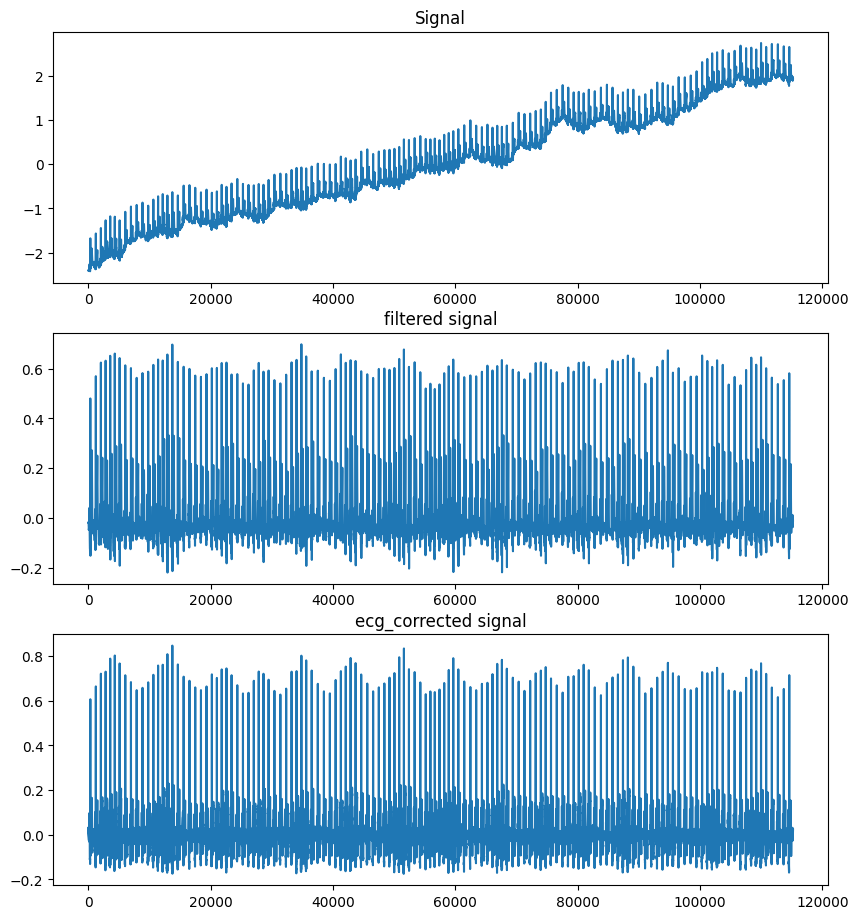

In [262]:
plt.figure(figsize=(10,15))
plt.subplot(4,1,1)
plt.plot(sig)
plt.title('Signal')

plt.subplot(4,1,2)
plt.plot(filtered_signal)
plt.title('filtered signal')

plt.subplot(4,1,3)
plt.plot(ecg_corrected)
plt.title('ecg_corrected signal')

Text(0.5, 1.0, 'one Segment')

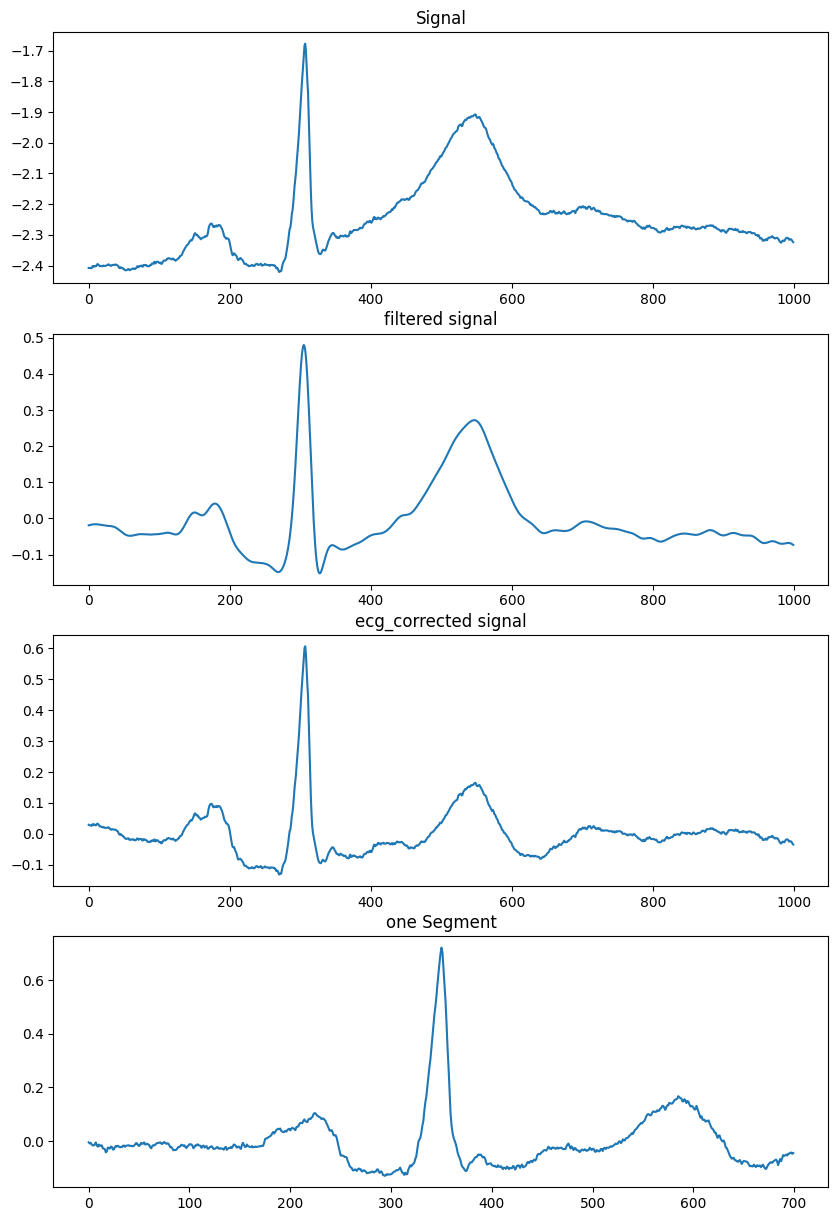

In [263]:
plt.figure(figsize=(10,15))
plt.subplot(4,1,1)
plt.plot(sig[0:1000])
plt.title('Signal')

plt.subplot(4,1,2)
plt.plot(filtered_signal[0:1000])
plt.title('filtered signal')

plt.subplot(4,1,3)
plt.plot(ecg_corrected[0:1000])
plt.title('ecg_corrected signal')

plt.subplot(4,1,4)
plt.plot(segments[0])
plt.title('one Segment')

# primary for the whole signal 

# start project code

In [264]:
segments_dict={}
for key ,sig in data.items():
    print(key,sig)
    
    ecg_corrected = ecg_isoline_drift_correction(sig, sampling_rate=1000)
    r_peaks, rr_intervals = ecg_segmentation(ecg_corrected, fs=1000, threshold=0.7)
    segments = extract_ecg_segments(ecg_corrected, r_peaks, fs=1000, window_size=0.7)
    
    segments_dict[key]=segments[2:52]

sub_1 [ 0.2265  0.218   0.215  ... -0.4795 -0.4835 -0.485 ]
sub_2 [ 0.0235  0.0245  0.027  ... -0.2265 -0.228  -0.233 ]
sub_3 [-2.408  -2.408  -2.4085 ...  1.904   1.9085  1.9155]
sub_4 [ 0.6845  0.682   0.6795 ... -0.5615 -0.557  -0.5545]
sub_5 [-0.3835 -0.386  -0.3865 ...  0.346   0.3475  0.343 ]


In [265]:
segments_dict['sub_1'].shape

(50, 700)

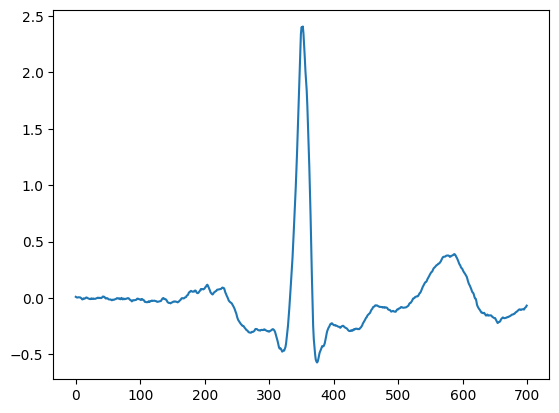

In [266]:
plt.plot(segments_dict['sub_1'][2])

# split data into train and test

In [267]:
segments_dict['sub_1']

array([[ 0.00793216,  0.00552282,  0.00364095, ..., -0.08734323,
        -0.08340569, -0.07754816],
       [ 0.00700258,  0.00946949,  0.00993638, ..., -0.07680649,
        -0.06830599, -0.06288052],
       [ 0.0110451 ,  0.00747464,  0.00386165, ..., -0.08391071,
        -0.07854359, -0.06712149],
       ...,
       [-0.00834095, -0.0097046 , -0.01006578, ..., -0.07450908,
        -0.07081731, -0.06818306],
       [ 0.00081562,  0.00256906,  0.00179747, ..., -0.07632706,
        -0.07001499, -0.05878043],
       [ 0.02085962,  0.01806473,  0.01325232, ..., -0.05581609,
        -0.05721703, -0.05217049]])

In [268]:
labels=[]
final_data=[]
for key ,signal in segments_dict.items():
    for s in signal:
        labels.append(key)
        final_data.append(s)

In [269]:
final_data=np.vstack(final_data)

In [270]:
labels=np.array(labels)

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(final_data,labels, test_size=0.20,stratify=labels,shuffle=True)

lb=LabelEncoder()

y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

# apply preprocessing on both train and test but separately

In [272]:
# fs = 1000
# cutoff_low = 2
# cutoff_high = 40
# nyquist = fs / 2
# level = int(np.floor(np.log2(nyquist/cutoff_low)))
# level

In [273]:
def preprocess_using_ACDCT(filtered_signal):
    sig=np.array(filtered_signal)
    AC=sm.tsa.acf(sig,nlags=1000)
    s=AC[0:100]
    DCT=scipy.fftpack.dct(s,type=2)
    
    return DCT

In [274]:
def preprocess_using_fiducial(filtered_signal):
    from fiducial_features import pan_tompkins
    
    features=pan_tompkins(filtered_signal)
    return features

In [275]:
def preprocess_using_wavelet(filtered_signal):  
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 4
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
    
    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, 'db4')
    return res

In [276]:
def preprocessing(signal,type_):
#     butterworth filter 2-40  or 2 -50 
#     sr=1000
    filtered_signal=butter_bandbass_filter(signal,low_cutoff=2,high_cutoff=40,sampling_rate=1000,order=4)
#     Features extraction using AC/DCT 
    
    if type_==1:
        features=preprocess_using_wavelet(filtered_signal)
    elif type_==2:
        features=preprocess_using_fiducial(filtered_signal)
    elif type_==3:
        features=preprocess_using_ACDCT(filtered_signal)
    
    return features

Text(0.5, 1.0, '4')

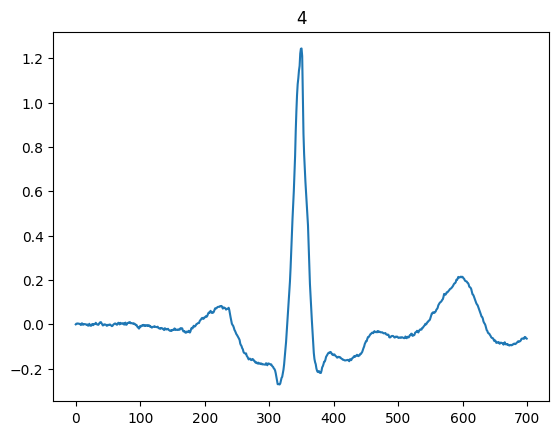

In [278]:
plt.plot(X_train[5])
plt.title(y_train[5])

In [279]:
# type_=1:use wavelet
# type_=2:use fiducial_features
# type_=3:use AC/DCT

type_=3
X_train=[preprocessing(d,type_) for d in X_train]
X_test=[preprocessing(d,type_) for d in X_test]

Text(0.5, 1.0, '4')

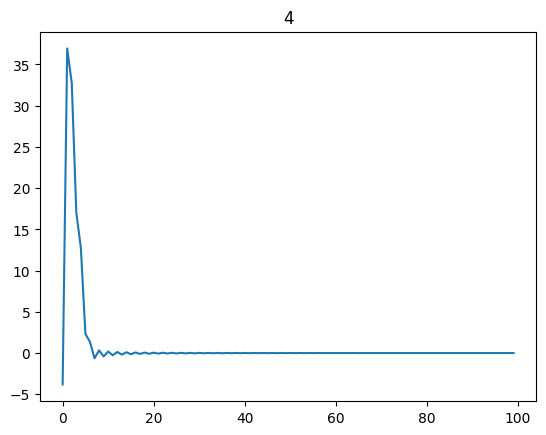

In [283]:
plt.plot(X_train[5])
plt.title(f'{y_train[5]}')

In [284]:
X_train=np.vstack(X_train)
X_train.shape

(200, 100)

In [285]:
X_test=np.vstack(X_test)
X_test.shape

(50, 100)

In [286]:
y_train[:10]

array([1, 4, 4, 4, 2, 4, 3, 0, 3, 1], dtype=int64)

In [287]:
# preprocessing
# filter data
# 10-40 butterworth
# extract features
# AC/DCT or wavelet
# normalization or PCA
# then train 

In [288]:
# segentation
# ui tkinter test saved in a separated file ,not preprcessed before
# fiducial features

# SVM

In [289]:
from sklearn import svm
from sklearn.metrics import accuracy_score ,classification_report,ConfusionMatrixDisplay,confusion_matrix

In [290]:
classifier = svm.SVC(kernel='linear') # Linear Kernel

classifier.fit(X=X_train,y=y_train)

pred=classifier.predict(X_test)

print("Accuracy = {} ".format(accuracy_score(y_test,pred)))

Accuracy = 1.0 


In [291]:
y_train

array([1, 4, 4, 4, 2, 4, 3, 0, 3, 1, 0, 1, 2, 4, 2, 4, 4, 3, 2, 3, 2, 4,
       3, 1, 3, 1, 3, 3, 4, 2, 2, 0, 3, 4, 0, 2, 4, 2, 1, 1, 3, 0, 1, 4,
       3, 0, 1, 3, 0, 1, 1, 0, 1, 0, 4, 4, 2, 4, 1, 1, 0, 3, 1, 2, 3, 0,
       4, 4, 2, 2, 2, 2, 3, 0, 3, 1, 1, 3, 1, 0, 2, 4, 4, 4, 2, 2, 1, 3,
       2, 2, 2, 0, 0, 1, 3, 0, 1, 2, 0, 1, 4, 0, 4, 3, 0, 2, 0, 0, 0, 0,
       1, 4, 2, 0, 1, 3, 0, 3, 0, 0, 4, 1, 1, 2, 3, 3, 3, 3, 4, 3, 0, 3,
       3, 1, 2, 0, 4, 2, 0, 4, 0, 2, 4, 3, 2, 4, 2, 4, 4, 3, 1, 0, 3, 1,
       3, 1, 2, 2, 4, 1, 2, 2, 4, 0, 1, 4, 0, 1, 0, 2, 4, 0, 1, 3, 2, 1,
       3, 2, 0, 2, 1, 1, 1, 2, 0, 0, 4, 3, 3, 3, 3, 4, 1, 4, 2, 3, 4, 1,
       0, 4], dtype=int64)

In [292]:
print(classification_report(y_test,pred,target_names=pd.unique(labels)))

              precision    recall  f1-score   support

       sub_1       1.00      1.00      1.00        10
       sub_2       1.00      1.00      1.00        10
       sub_3       1.00      1.00      1.00        10
       sub_4       1.00      1.00      1.00        10
       sub_5       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



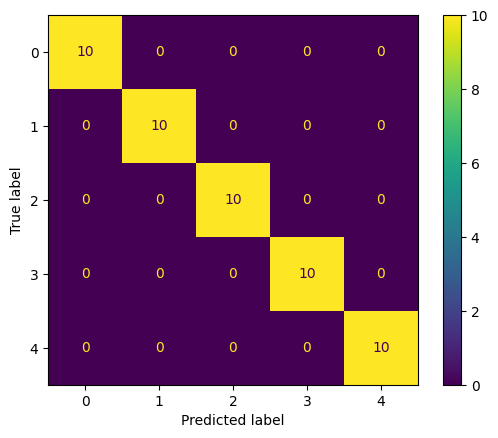

In [293]:
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# LogisticRegression

In [294]:
from sklearn.linear_model import LogisticRegression

classifier=LogisticRegression()

classifier.fit(X=X_train,y=y_train)

pred=classifier.predict(X_test)

print("Accuracy = {} ".format(accuracy_score(y_test,pred)))

Accuracy = 0.98 


# LDA

In [295]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [296]:
classifier=LinearDiscriminantAnalysis()

classifier.fit(X=X_train,y=y_train)

pred=classifier.predict(X_test)

print("Accuracy = {} ".format(accuracy_score(y_test,pred)))

Accuracy = 1.0 


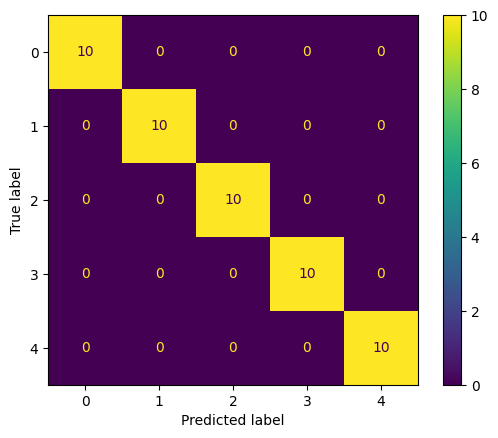

In [297]:
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()